In [1]:
%matplotlib inline

# Primitive Device Modeling using Deep Neural Networks

In [2]:
from google.colab import files, drive

import os
import datetime
from pathlib import Path

import pandas as pd

import numpy as np
import sympy as sym
import scipy as sp
from scipy import optimize, interpolate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

import joblib
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection._split import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader

## Setup

Here primitive devices are modeled using Deep Neural Networks. 
The Data used to train these models is obtained from the PREDICT toolbox.

Create working directory for checkpoint saving and log dir for tensorboard.

In [22]:
model_name = 'pmos1v'
model_type = 'p'
prefix = './' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/' + model_name
Path(prefix).mkdir(parents=True, exist_ok=True)

Path('./data/').mkdir(parents=True, exist_ok=True)

#### Runtime

**Note on CUDA support**: Make sure to go to `Runtime` > `Change runtime type`
and select **GPU**, to enable CUDA Support for this notebook.

In [23]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("We're running on a", torch.cuda.get_device_name())

We're running on a Tesla P100-PCIE-16GB


## Data

Instead of repeadetly simulating the device, to get the _labels_ for training the NN, use the predict toolbox to characterize the divce once and generate enough data for the entire training process. How much data this needs to be remains to be seen.

Here the data is given by a pandas dataframe, read from a `.h5` database.

### Mount G-Drive

If not done so already, mount the G-Drive to load a predict database.

In [24]:
drive_prefix = '/content/drive'

if not os.path.isdir(drive_prefix):
    drive.mount(drive_prefix)

drive_prefix = drive_prefix + '/My Drive/ML-Data'

### Loading Data
Loading the `.h5` data frame may crash. This is beacuse by default only $12$ GB of RAM are allocated for any colab session. However, after the crash a popup should come up asking if you wish to upgrade to a higher RAM backend. Choose '_Yes_' if you wish to continue with this notebook.

In [25]:
mos_file = drive_prefix + '/' + model_name + '.h5'

if os.path.isfile(mos_file):
    df = pd.read_hdf(mos_file, 'database')
    df = df[np.isfinite(df).all(1)]
    df = df.dropna()
else:
    raise FileNotFoundError('HDF5 database not found!')

### Preprocessing

The resulting dataframe will be filtered and reduced to the absolute necessary,
in order to preserve RAM.

In [26]:
param_names = df.columns.tolist()
dp_names = [p for p in param_names if 'OPP' not in p]
pp_names = [p for p in param_names if 'OPP' in p]

#print(f"IPs: {dp_names}\nOPs: {pp_names}")

In [27]:
V_O = 'V_D' if model_type == 'n' else 'V_S'
ipp_names = [ 'P_l', V_O, 'V_G', 'V_B' ]
opp_names = [ 'OPP_id', 'OPP_fug'
            , 'OPP_vth', 'OPP_vdsat'
            , 'OPP_gm', 'OPP_gds', 'OPP_gmb'
            , 'OPP_cgd', 'OPP_cgs', 'OPP_cgb'
            , 'OPP_cds', 'OPP_cdb', 'OPP_csb' ]

ipp_idx = [param_names.index(p) for p in ipp_names]
opp_idx = [param_names.index(p) for p in opp_names]

num_ipp = len(ipp_names)
num_opp = len(opp_names)

#data = df.values
input_raw = df[ipp_names].values
output_raw = df[opp_names].values

This data is anything but uniformly distributed. This can be rectified 
with the **Quantile Transformer** (_scikit learn_),
which maps any data onto either a normal, or a uniform distribution.

In this case, _uniform_ is the distribution of choice. 
However for Gaussian Processes, the _normal_ distribution 
might be the right choice. 

In [28]:
input_transformer = QuantileTransformer( output_distribution='uniform'
                                       , random_state=42 )
output_transformer = QuantileTransformer( output_distribution='uniform'
                                        , random_state=42 )

input_data = input_transformer.fit_transform(input_raw)
output_data = output_transformer.fit_transform(output_raw)

joblib.dump(input_transformer, (prefix + '.input'))
joblib.dump(output_transformer, (prefix + '.output'))

['./20200710-111433/pmos1v.output']

After transforming the data, the corresponding transformers are stored, 
for later use. Since the network learns only on data normalized 
in this specific way, the transformers are necessary to 
test and deploy the network later.

### Initializing processed Data for training

Here the number of epochs, batch size and data split ratio are specified.

**Important**: Keep the batch size as smalle as possible, preferrably 
$b_{size} < 10000$. Otherwise the network will converge to a mean value as
opposed to the actual target.

In [29]:
batch_size = 500
test_split = 0.2

X_train,\
X_valid,\
Y_train,\
Y_valid = train_test_split( input_data
                          , output_data
                          , test_size=test_split
                          , shuffle=True
                          , random_state=42 )

train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
valid_set = TensorDataset(torch.Tensor(X_valid), torch.Tensor(Y_valid))

train_loader = DataLoader(train_set, batch_size, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size, pin_memory=True)

## Deep Neural Network for Device Modeling

The Neural Network defined here, takes `num_ipp` input parameters,
and maps them to `num_opp` output parameters:

$$
\begin{bmatrix}
V_{GS}\\ V_{DS}\\ V_{BS}\\L
\end{bmatrix}
\Rightarrow
\begin{bmatrix}
    i_{d}\\ f_{ug}\\ V_{th}\\ V_{d,sat}\\ g_{m}\\ g_{mb}\\ g_{ds}\\ 
    C_{gs}\\ C_{gd}\\ C_{gb}\\ C_{ds}\\ C_{db}\\ C_{sb}\\
\end{bmatrix}
$$

In [30]:
class TransistorNet(nn.Module):
    def __init__(self, num_dps, num_pps):
        super(TransistorNet, self).__init__()
        self.fc_1 = nn.Linear(num_dps, 128)
        self.fc_2 = nn.Linear(128, 256)
        self.fc_3 = nn.Linear(256, 512)
        self.fc_4 = nn.Linear(512, 1024)
        self.fc_5 = nn.Linear(1024, 512)
        self.fc_6 = nn.Linear(512, 256)
        self.fc_7 = nn.Linear(256, 128)
        self.out = nn.Linear(128, num_pps)

    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        x = F.relu(self.fc_4(x))
        x = F.relu(self.fc_5(x))
        x = F.relu(self.fc_6(x))
        x = F.relu(self.fc_7(x))
        out = self.out(x)
        return out

In [31]:
mos_net = TransistorNet(num_ipp, num_opp)
mos_net = mos_net.to(device)

## Loss and Optimization

For this _regression_ problem the **Mean Squared Error** (MSE) is used 
as loss function. To visualize the training process, 
the **Mean Absolute Error** (MAE) is additionally observed. 
However the latter does not influence the learning process.

As optimizer **AdamW** is chosen, since epxeriments have shown, 
that this optimzier converges the fastes. Aternatively, _Adam_ also
works quite well.

In [32]:
loss_mse        = nn.MSELoss()
loss_mae        = nn.L1Loss()
train_losses    = []
valid_losses    = []
optimizer       = optim.Adam(mos_net.parameters())
#optimizer       = optim.AdamW(mos_net.parameters())

## Training

The loop iterates over the defined number of epochs (`num_epochs`). 
As mentioned earlier, I do not know if tensorboard works on google colab, 
if it does the training process can be viewed there, 
otherwise the console output has tu suffice during the training, 
but a sumary will be plotted afterwards. 

In [ ]:
best_candidate = None
num_epochs = 100
for epoch in range(num_epochs):
    t0 = datetime.datetime.now().replace(microsecond=0)
    
    train_mse, train_mae, valid_mse, valid_mae = 0., 0., 0., 0.
    mos_net.train()

    for X_train, Y_train in train_loader:
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)

        optimizer.zero_grad()

        out_train = mos_net(X_train)

        mse = loss_mse(out_train, Y_train)
        mae = loss_mae(out_train, Y_train)

        mse.backward()
        optimizer.step()

        train_mse += mse.item()
        train_mae += mae.item()

    with torch.no_grad():
        mos_net.eval()
        for X_valid, Y_valid in valid_loader:
            X_valid = X_valid.to(device)
            Y_valid = Y_valid.to(device)

            out_valid = mos_net(X_valid)

            valid_mse += loss_mse(out_valid, Y_valid).item()
            valid_mae += loss_mae(out_valid, Y_valid).item()

    train_mse_avg = train_mse / len(train_loader)
    train_mae_avg = train_mae / len(train_loader)
    valid_mse_avg = valid_mse / len(valid_loader)
    valid_mae_avg = valid_mae / len(valid_loader)

    t1 = datetime.datetime.now().replace(microsecond=0)

    train_losses.append(train_mse_avg)
    valid_losses.append(valid_mae_avg)
    epc_str = f"[{t0} - {t1}] Epoch {epoch + 1}/{num_epochs}:"
    mse_str = f"Training MSE: {train_mse_avg}"
    mae_str = f"Validation MAE: {valid_mae_avg}"
    print(epc_str + "\n\t" + mse_str + "\n\t" + mae_str)
    
    if best_candidate == None or best_candidate > valid_mae_avg:
        best_candidate = valid_mae_avg
        torch.save(mos_net.state_dict(), (prefix + '.model'))
        print(f"\tNew Candidate Net Saved!")

[2020-07-10 11:17:04 - 2020-07-10 11:20:24] Epoch 1/100:
	Training MSE: 0.0013443226858582838
	Validation MAE: 0.009625094145744492
	New Candidate Net Saved!


### Plot Learning Progress

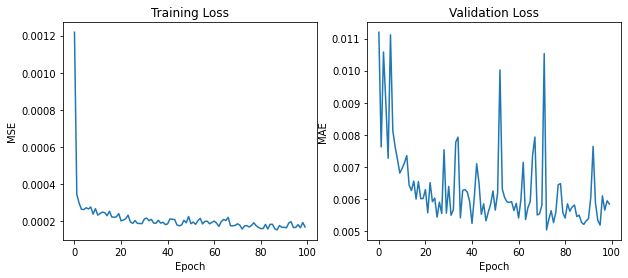

In [15]:
fig = plt.figure(figsize=plt.figaspect(0.4))
ax_train = fig.add_subplot(1, 2, 1)
ax_train.plot(range(num_epochs), train_losses)
ax_train.set_xlabel("Epoch")
ax_train.set_ylabel("MSE")
ax_train.set_title("Training Loss")

ax_valid = fig.add_subplot(1, 2, 2)
ax_valid.plot(range(num_epochs), valid_losses)
ax_valid.set_xlabel("Epoch")
ax_valid.set_ylabel("MAE")
ax_valid.set_title("Validation Loss")
plt.show()

### Save Current Best Model to Drive

In [16]:
drive_path = './drive/My Drive/ML-Data/model/'

if os.path.isdir(drive_path):
    os.system('rm -rf ' + drive_path)

Path(drive_path).mkdir(parents=True, exist_ok=True)

os.system('cp ' + prefix + 'model.pt ' + drive_path)
os.system('cp ' + prefix + 'input.trafo ' + drive_path)
os.system('cp ' + prefix + 'output.trafo ' + drive_path)

256

## Validation

For Validating the model, a `predict` function is defined. It takes $4$ DPs 
as input and evaluates a trained model, 
returning the correspoding $11$ OPPs, that were predicted by the NN.

For testing an already trained model, specify the `model_checkpoint` here.
If `None` is given, the current `prefix` directory will be used to get the 
model and the transformers.

In [17]:
model_checkpoint = None
#model_checkpoint = './20200427-131529/' + model_name

if model_checkpoint is None:
    input_trafo = joblib.load(prefix + '.input')
    output_trafo = joblib.load(prefix + '.output')
else:
    input_trafo = joblib.load(model_checkpoint + '.input')
    output_trafo = joblib.load(model_checkpoint + '.output')

In [18]:
def predict (input_data, batch_size, model_checkpoint=None):
    net = TransistorNet(num_ipp,num_opp)
    net.to(device)

    if model_checkpoint is None:
        net.load_state_dict(torch.load(prefix + '.model'))
    else:
        net.load_state_dict(torch.load(model_checkpoint + '.model')) 

    net.eval()

    input_transformed = input_trafo.transform(input_data)
    input_set = TensorDataset(torch.Tensor(input_transformed))
    input_loader = DataLoader(input_set, batch_size)
    output_data = None

    for batch in input_loader:
        prediction = net(batch[0].to(device))
        prediction = prediction.to("cpu").data.numpy()
        prediction = output_trafo.inverse_transform(prediction)

        if output_data is None:
            output_data = prediction
        else:
            output_data = np.concatenate((output_data, prediction), axis=0)
            
    return output_data

### Specification

To validate the model, it has to predict the Transfer Characteristic,
as well as the Output Characteristic of the Device.
This gives a 3D plot that can be compared to the ground truth.
For this, $V_{B} = 0.0 V$ and $L = 300 nm$ are fixed,
while $V_{G}$ and $V_{D}$ are sweeped. 
The NN then has to predict all $11$ OPPs. 
However in the plot, only $i_{d}$ will be shown.

### Filter Database

The database is filtered according to the specification to obtain the
ground truth and the input data.



In [19]:
Pl_tru = 3e-7
VB_tru = 0.0

data_tru = df[ (df['P_l'] == Pl_tru)
             & (df[V_O] >= 0.0)
             & (df['V_G'] >= 0.0)
             & (df['V_B'] == VB_tru) ]\
             [ ipp_names + ['OPP_id'] ]

VG_tru  = data_tru.V_G.values

VO_tru  = data_tru.V_D.values if model_type == 'n' \
                              else data_tru.V_S.values

### Obtain Ground Truth and Prediction

Generate meshgrid of $i_{d}$ for varying $V_{D}$ and $V_{G}$.

In [20]:
ID2D_tru = np.empty((0,60))
ID2D_prd = np.empty((0,60))

i_d = lambda x: predict(x, x.shape[0])[:,opp_names.index('OPP_id')]

for vg in np.unique(VG_tru):
    input_data  = data_tru[(data_tru.V_G == vg)][ipp_names].values
    id_tru      = data_tru[(data_tru.V_G == vg)]['OPP_id'].values
    id_prd      = i_d(input_data)
    ID2D_tru    = np.vstack((ID2D_tru, id_tru))
    ID2D_prd    = np.vstack((ID2D_prd, id_prd))

### Plot Results

Show 3D plot of prediction and ground truth next to each other for a direct
comparison of model quality.

Training Results after 100 epochs


None

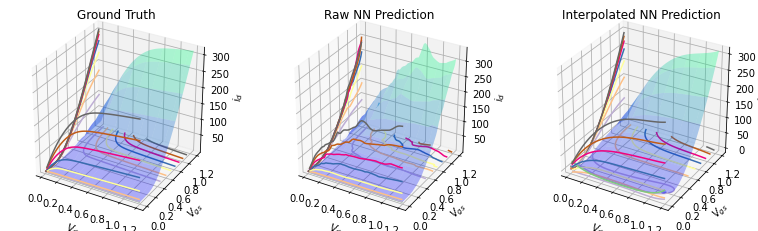

In [21]:
fig = plt.figure(figsize=plt.figaspect(0.3))

X, Y = np.meshgrid(np.unique(VO_tru), np.unique(VG_tru))

ax = fig.add_subplot(1, 3, 1, projection='3d')
Z = ID2D_tru
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3, cmap=cm.winter)
cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.Accent)
cset = ax.contour(X, Y, Z, zdir='x', offset=0 , cmap=cm.Accent)
cset = ax.contour(X, Y, Z, zdir='y', offset=0  , cmap=cm.Accent)
ax.set_xlabel('$V_{ds}$')
ax.set_ylabel('$V_{gs}$')
ax.set_zlabel('$i_{d}$')
ax.set_title('Ground Truth')

ax = fig.add_subplot(1, 3, 2, projection='3d')
Z = ID2D_prd
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3, cmap=cm.winter)
cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.Accent)
cset = ax.contour(X, Y, Z, zdir='x', offset=0 , cmap=cm.Accent)
cset = ax.contour(X, Y, Z, zdir='y', offset=0  , cmap=cm.Accent)
ax.set_xlabel('$V_{ds}$')
ax.set_ylabel('$V_{gs}$')
ax.set_zlabel('$i_{d}$')
ax.set_title('Raw NN Prediction')

ax = fig.add_subplot(1, 3, 3, projection='3d')
spline = sp.interpolate.Rbf(X, Y, Z, function='quintic', smooth=2)
Z = spline(X,Y)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3, cmap=cm.winter)
cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.Accent)
cset = ax.contour(X, Y, Z, zdir='x', offset=0 , cmap=cm.Accent)
cset = ax.contour(X, Y, Z, zdir='y', offset=0  , cmap=cm.Accent)
ax.set_xlabel('$V_{ds}$')
ax.set_ylabel('$V_{gs}$')
ax.set_zlabel('$i_{d}$')
ax.set_title('Interpolated NN Prediction')

display(print(f"Training Results after {num_epochs} epochs"))
plt.show()